<div style = "font-family:Georgia;
              font-size:2.5vw;
              color:lightblue;
              font-style:bold;
              text-align:center;
              background:url('Title Background.gif') no-repeat center;
              background-size:cover)">
              
     <br><br>
     You Only Look Once (YOLO)
     <br><br><br>
     
</div>

##### Introduction

YOLO is a state-of-the-art, real-time object detection algorithm. In this notebook, we will apply the YOLO algorithm to detect objects in images. 


##### Reference

[Original Paper](https://arxiv.org/pdf/1506.02640.pdf)


### What is YOLO
YOLO divides the input image into an S×S grid cell.

**For each grid cell,**

1. YOLO predicts B boundary boxes and each box has one box confidence score,
2. YOLO detects one object only regardless of the number of boxes B,
3. YOLO predicts C conditional class probabilities (one per class for the likeliness of the object class).

In this example, the yellow grid cell makes two boundary box predictions (blue boxes) to locate where the person is.

<img src="YOLO_1.jpeg">

### Detail

1. Each boundary box contains 5 elements: (x, y, w, h) and a box confidence score. The confidence score reflects how likely the box contains an object (objectness) and how accurate is the boundary box. 

2. We normalize the bounding box width w and height h by the image width and height. x and y are offsets to the corresponding cell. Hence, x, y, w and h are all between 0 and 1.

3. Each cell has 20 conditional class probabilities. The conditional class probability is the probability that the detected object belongs to a particular class.

4. To evaluate PASCAL VOC, YOLO uses 7×7 grids (S×S), 2 boundary boxes (B) and 20 classes (C).

5. So, YOLO’s prediction has a shape of (S, S, B×5 + C) = (7, 7, 2×5 + 20) = (7, 7, 30).

### Network design

The major concept of YOLO is to build a CNN network to predict a (7, 7, 30) tensor.

YOLO has 24 convolutional layers followed by 2 fully connected layers (FC). Some convolution layers use 1 × 1 reduction layers alternatively to reduce the depth of the features maps. For the last convolution layer, it outputs a tensor with shape (7, 7, 1024). The tensor is then flattened. Using 2 fully connected layers as a form of linear regression, it outputs 7×7×30 parameters and then reshapes to (7, 7, 30), i.e. 2 boundary box predictions per location.

### Loss function

<img src=YOLO_2.png>


YOLO uses sum-squared error between the predictions and the ground truth to calculate loss. The loss function composes of:

1. the classification loss.
2. the localization loss (errors between the predicted boundary box and the ground truth).
3. the confidence loss (the objectness of the box).

The final loss adds localization, confidence and classification losses together.

### Inference: Non-maximal suppression
YOLO can make duplicate detections for the same object. To fix this, YOLO applies non-maximal suppression to remove duplications with lower confidence. Non-maximal suppression adds 2- 3% in mAP.

Here is one of the possible non-maximal suppression implementation:

1. Sort the predictions by the confidence scores.
2. Start from the top scores, ignore any current prediction if we find any previous predictions that have the same class and IoU > 0.5 with the current prediction.
3. Repeat step 2 until all predictions are checked.

### Benefits of YOLO

1. Fast. Good for real-time processing.
2. Predictions (object locations and classes) are made from one single network. Can be trained end-to-end to improve accuracy.
3. YOLO is more generalized. It outperforms other methods when generalizing from natural images to other domains like artwork.
4. Region proposal methods limit the classifier to the specific region. YOLO accesses to the whole image in predicting boundaries. With the additional context, YOLO demonstrates fewer false positives in background areas.
5. YOLO detects one object per grid cell. It enforces spatial diversity in making predictions.

### Limitation
However, the one-object rule limits how close detected objects can be. For that, YOLO does have some limitations on how close objects can be. 

## YOLOv2

**Accuracy Improvement** <br>
SSD is a strong competitor for YOLO which at one point demonstrates higher accuracy for real-time processing. Comparing with region based detectors, YOLO has higher localization errors and the recall (measure how good to locate all objects) is lower. YOLOv2 is the second version of the YOLO with the objective of improving the accuracy significantly while making it faster.

Here is the accuracy improvements after applying the various techniques:

<img src="YOLO_3.png">


Accuracy comparison for different detectors:

<img src="YOLO_4.png">

**Speed improvement** <br><br>

<font color='red'> GoogLeNet </font>

VGG16 requires 30.69 billion floating point operations for a single pass over a 224 × 224 image versus 8.52 billion operations for a customized GoogLeNet. We can replace the VGG16 with the customized GoogLeNet. However, YOLO pays a price on the top-5 accuracy for ImageNet: accuracy drops from 90.0% to 88.0%.


<font color='red'> DarkNet </font>

We can further simplify the backbone CNN used. Darknet requires 5.58 billion operations only. With DarkNet, YOLO achieves 72.9% top-1 accuracy and 91.2% top-5 accuracy on ImageNet. Darknet uses mostly 3 × 3 filters to extract features and 1 × 1 filters to reduce output channels. It also uses global average pooling to make predictions.

### Training
YOLO is trained with the ImageNet 1000 class classification dataset in 160 epochs: using stochastic gradient descent with a starting learning rate of 0.1

### Classification
Datasets for object detection have far fewer class categories than those for classification. To expand the classes that YOLO can detect, YOLO proposes a method to mix images from both detection and classification datasets during training.

YOLO combines labels in different datasets to form a tree-like structure WordTree (Hierarchical classification).

<img src="YOLO_5.png">

The class probability is computed from the YOLO predictions by going up the WordTree.

<img src="YOLO_6.png">

One benefit of the hierarchy classification is that when YOLO cannot distinguish the type of airplane, it gives a high score to the airplane instead of forcing it into one of the sub-categories.



## YOLO v3

### Class Prediction
Most classifiers assume output labels are mutually exclusive. Therefore, YOLO applies a softmax function to convert scores into probabilities that sum up to one. 

YOLOv3 uses multi-label classification. For example, the output labels may be “pedestrian” and “child” which are not non-exclusive. (the sum of output can be greater than 1 now.) YOLOv3 replaces the softmax function with independent logistic classifiers to calculate the likeliness of the input belongs to a specific label.

Instead of using mean square error in calculating the classification loss, YOLOv3 uses binary cross-entropy loss for each label. This also reduces the computation complexity by avoiding the softmax function.

### Bounding box prediction & cost function calculation

1. YOLOv3 predicts an objectness score for each bounding box using logistic regression. 
2. YOLOv3 changes the way in calculating the cost function. If the bounding box prior (anchor) overlaps a ground truth object more than others, the corresponding objectness score should be 1. 
3. For other priors with overlap greater than a predefined threshold (default 0.5), they incur no cost. 
4. Each ground truth object is associated with one boundary box prior only. 
5. If a bounding box prior is not assigned, it incurs no classification and localization loss, just confidence loss on objectness. We use tx and ty (instead of bx and by) to compute the loss.

### Feature Pyramid Networks (FPN) like Feature Pyramid

YOLOv3 makes 3 predictions per location. Each prediction composes of a boundary box, a objectness and 80 class scores, i.e. N × N × [3 × (4 + 1 + 80) ] predictions.

YOLOv3 makes predictions at 3 different scales (similar to the FPN):

1. In the last feature map layer.

2. Then it goes back 2 layers back and upsamples it by 2. YOLOv3 then takes a feature map with higher resolution and merge it with the upsampled feature map using element-wise addition. YOLOv3 apply convolutional filters on the merged map to make the second set of predictions.

3. Repeat 2 again so the resulted feature map layer has good high-level structure (semantic) information and good resolution spatial information on object locations. <br>

To determine the priors, YOLOv3 applies k-means cluster. Then it pre-select 9 clusters. For COCO, the width and height of the anchors are (10×13),(16×30),(33×23),(30×61),(62×45),(59× 119),(116 × 90),(156 × 198),(373 × 326). These 9 priors are grouped into 3 different groups according to their scale. Each group is assigned to a specific feature map above in detecting objects.

### Feature extractor

A new 53-layer Darknet-53 is used to replace the Darknet-19 as the feature extractor. Darknet-53 mainly compose of 3 × 3 and 1× 1 filters with skip connections like the residual network in ResNet. Darknet-53 has less BFLOP (billion floating point operations) than ResNet-152, but achieves the same classification accuracy at 2x faster.

### YOLOv3 performance

YOLOv3's COCO AP (average precision) metric is on par with SSD but 3x faster. But YOLOv3’s AP is still behind RetinaNet. In particular, AP@IoU=.75 drops significantly comparing with RetinaNet which suggests YOLOv3 has higher localization error. YOLOv3 also shows significant improvement in detecting small objects. <br>

YOLOv3 performs very well in the fast detector category when speed is important.

<img src="YOLO_7.png">



<img src="YOLO_8.png">

# Importing Resources

We will start by loading the required packages into Python. We will be using *OpenCV* to load our images, *matplotlib* to plot them, a`utils` module that contains some helper functions, and a modified version of *Darknet*. YOLO uses *Darknet*, an open source, deep neural network framework written by the creators of YOLO. The version of *Darknet* used in this notebook has been modified to work in PyTorch 0.4 and has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the Common Objects in Context (COCO) database. For more information on *Darknet*, please visit <a href="https://pjreddie.com/darknet/">Darknet</a>.

In [1]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

# Setting Up The Neural Network

We will be using the latest version of YOLO, known as YOLOv3. We have already downloaded the `yolov3.cfg` file that contains the network architecture used by YOLOv3. Similarly, we have placed the `yolov3.weights` file that contains the pre-trained weights. Finally, the `coco.names` file that has the list of the 80 object classes that the weights were trained to detect.

In the code below, we start by specifying the location of the files that contain the neural network architecture, the pre-trained weights, and the object classes.  We then use *Darknet* to setup the neural network using the network architecture specified in the `cfg_file`. We then use the`.load_weights()` method to load our set of pre-trained weights into the model. Finally, we use the `load_class_names()` function, from the `utils` module, to load the 80 object classes.

In [2]:
# Set the location and name of the cfg file
cfg_file = 'yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = 'yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'coco.names'

# Load the network architecture
m = Darknet(cfg_file)

# Load the pre-trained weights
m.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

In [3]:
# Print the neural network used in YOLOv3
m.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

As we can see, the neural network used by YOLOv3 consists mainly of convolutional layers, with some shortcut connections and upsample layers. For a full description of this network please refer to the <a href="https://pjreddie.com/media/files/papers/YOLOv3.pdf">YOLOv3 Paper</a>.

# Loading and Resizing Our Images

In the code below, we load our images using OpenCV's `cv2.imread()` function. Since, this function loads images as BGR we will convert our images to RGB so we can display them with the correct colors.

As we can see in the previous cell, the input size of the first layer of the network is 416 x 416 x 3. Since images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network. In the code below, we resize our images using OpenCV's `cv2.resize()` function. We then plot the original and resized images.

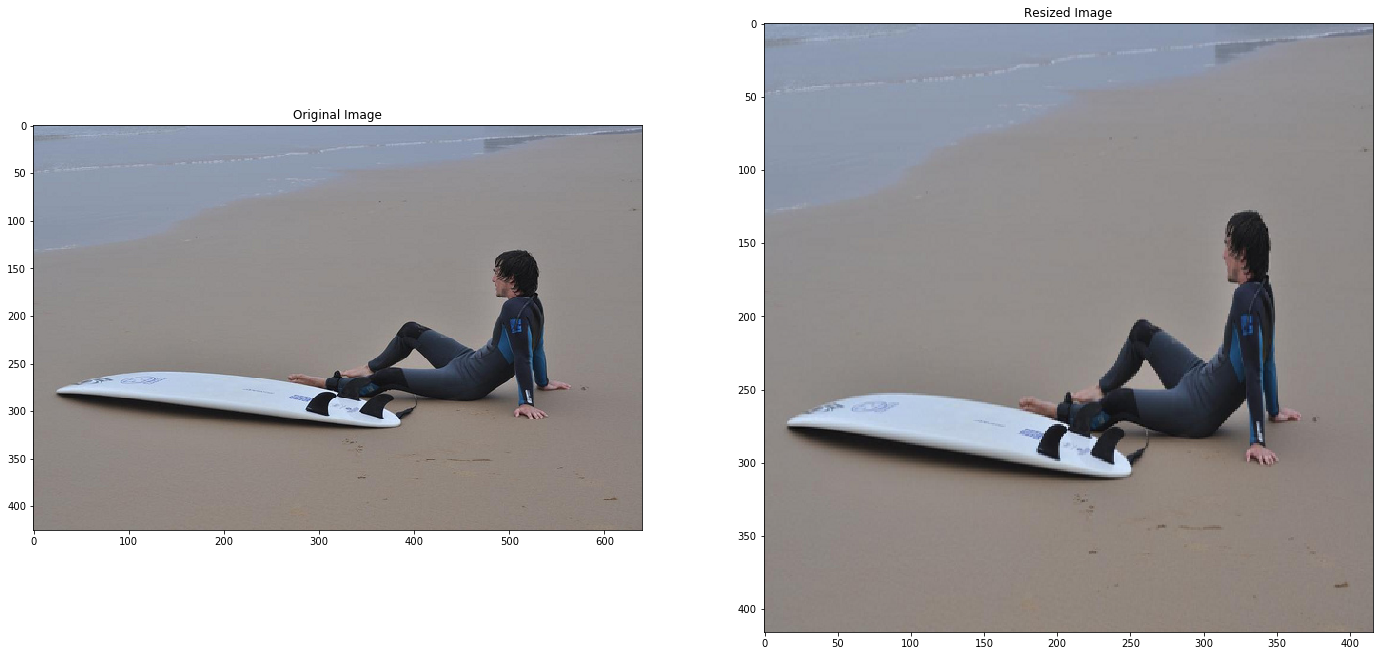

In [4]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('surf.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Display the images
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(122)
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

# Setting the Non-Maximal Suppression Threshold

As you learned in the previous lessons, YOLO uses **Non-Maximal Suppression (NMS)** to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold.  In the code below, we set this NMS threshold to `0.6`. This means that all predicted bounding boxes that have a detection probability less than 0.6 will be removed. 

In [5]:
# Set the NMS threshold
nms_thresh = 0.6

# Setting the Intersection Over Union Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose **Intersection Over Union (IOU)** value is higher than a given IOU threshold. In the code below, we set this IOU threshold to `0.4`. This means that all predicted bounding boxes that have an IOU value greater than 0.4 with respect to the best bounding boxes will be removed.

In the `utils` module you will find the `nms` function, that performs the second step of Non-Maximal Suppression, and the `boxes_iou` function that calculates the Intersection over Union of two given bounding boxes. You are encouraged to look at these functions to see how they work. 

In [6]:
# Set the IOU threshold
iou_thresh = 0.4

# Object Detection

Once the image has been loaded and resized, and you have chosen your parameters for `nms_thresh` and `iou_thresh`, we can use the YOLO algorithm to detect objects in the image. We detect the objects using the `detect_objects(m, resized_image, iou_thresh, nms_thresh)`function from the `utils` module. This function takes in the model `m` returned by *Darknet*, the resized image, and the NMS and IOU thresholds, and returns the bounding boxes of the objects found.

Each bounding box contains 7 parameters: the coordinates *(x, y)* of the center of the bounding box, the width *w* and height *h* of the bounding box, the confidence detection level, the object class probability, and the object class id. The `detect_objects()` function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected. Since we are running the algorithm on a CPU it takes about 2 seconds to detect the objects in an image, however, if we were to use a GPU it would run much faster.

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the `print_objects()` function in the `utils` module.

Finally, we use the `plot_boxes()` function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. If you set the `plot_labels` flag to `False` you will display the bounding boxes with no labels. This makes it easier to view the bounding boxes if your `nms_thresh` is too low. The `plot_boxes()`function uses the same color to plot the bounding boxes of the same object class. However, if you want all bounding boxes to be the same color, you can use the `color` keyword to set the desired color. For example, if you want all the bounding boxes to be red you can use:

`plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))`

You are encouraged to change the `iou_thresh` and `nms_thresh` parameters to see how they affect the YOLO detection algorithm. The default values of `iou_thresh = 0.4` and `nms_thresh = 0.6` work well to detect objects in different kinds of images. In the cell below, we have repeated some of the code used before in order to prevent you from scrolling up down when you want to change the `iou_thresh` and `nms_thresh`parameters or the image. Have Fun!



It took 1.344 seconds to detect the objects in the image.

Number of Objects Detected: 2 

Objects Found and Confidence Level:

1. person: 1.000000
2. surfboard: 0.994814


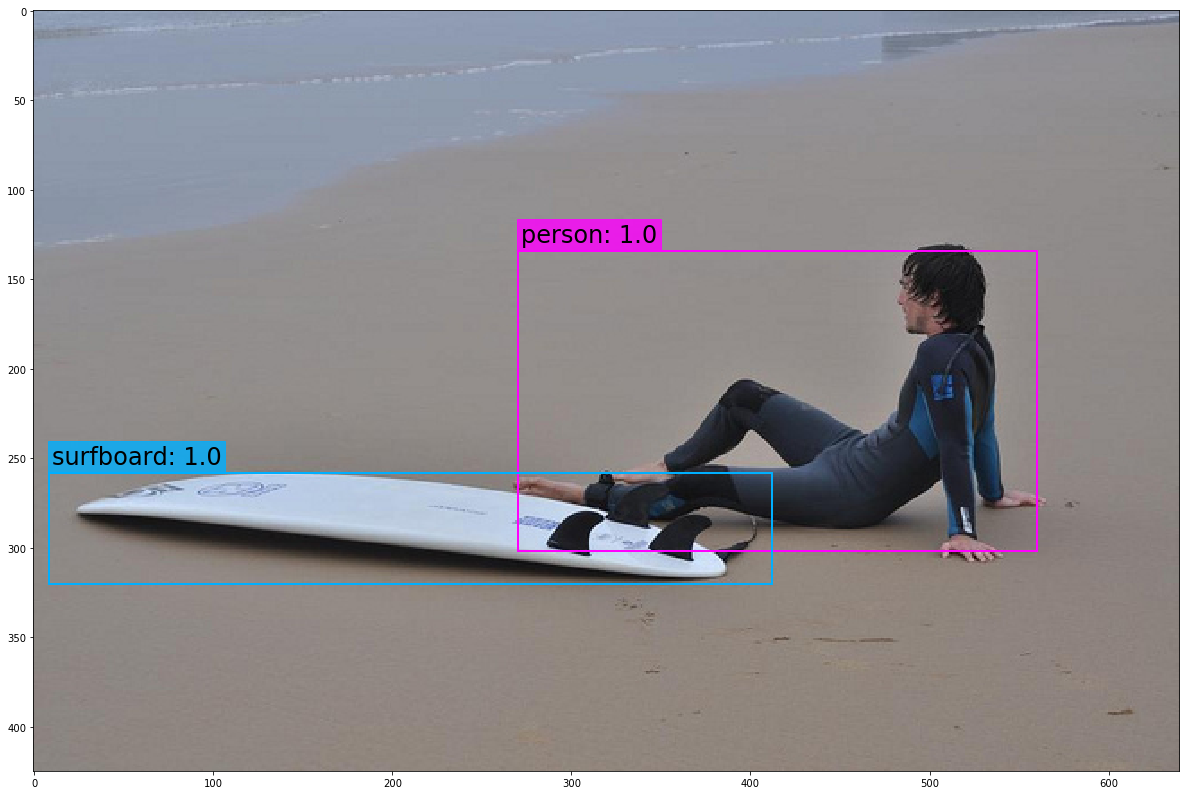

In [7]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]

# Load the image
img = cv2.imread('surf.jpg')

# Convert the image to RGB
original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_image, (m.width, m.height))

# Set the IOU threshold. Default value is 0.4
iou_thresh = 0.4

# Set the NMS threshold. Default value is 0.6
nms_thresh = 0.6

# Detect objects in the image
boxes = detect_objects(m, resized_image, iou_thresh, nms_thresh)

# Print the objects found and the confidence level
print_objects(boxes, class_names)

#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_image, boxes, class_names, plot_labels = True)